In [28]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from decimal import Decimal
from matplotlib import pylab
from matplotlib import pyplot as plt
from matplotlib import rc
from mendeleev import element
from itertools import chain, combinations
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, LeaveOneOut
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

%matplotlib inline 
datapath = './linear_regression/data/ORR_OH_ads.tsv'
outpath = './linear_regression/ORR_results/'


In [29]:
# Setup plotting parameters.
plt.rc('text', usetex=False)
font = {'family': 'sans-serif',
        # 'sans-serif':, 'Helvetica',
        'style': 'normal',
        'stretch': 'normal'}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.rc('figure')
plt.rc('lines', markeredgewidth=0, markersize=8, linewidth=1)
ticksize = 14
plt.rc('font', size=ticksize+4)
plt.rc('xtick', labelsize=ticksize+2)
plt.rc('ytick.major', size=6, width=2)
plt.rc('ytick.minor', size=6, width=2)
plt.rc('ytick', labelsize=ticksize+2)
plt.rc('ytick.major', size=6, width=2)
plt.rc('ytick.minor', size=6, width=2)

colors=['#a6cee3','#fdbf6f','#b2df8a','#1f78b4','#e31a1c','#fb9a99','#33a02c']
tcolor='#737373'
bcolor='#252525'
symbols=['D','^','o']

'''Extensive materials style dictionary
Usage: mdict[key1][key2] with
key1 = Atomic number of metal
key2 = Number of H atoms in stoichiometric unit of the LDH'''

mdict = {  22 : [
                ['Ti', r'$TiO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','green',symbols[2],colors[0]],
                ['Ti', r'$TiOOH-OH$',tcolor,0.0,0.08,1.5,'8','green',symbols[1],colors[0]],
                ['Ti', r'$Ti(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','green',symbols[0],colors[0]]
                ],
           23 : [
                ['V', r'$VO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','black',symbols[2],colors[1]],
                ['V', r'$VOOH-OH$',tcolor,0.0,0.08,1.5,'8','black',symbols[1],colors[1]],
                ['V', r'$V(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','black',symbols[0],colors[1]]
                ],
           24 : [
                ['Cr', r'$CrO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','yellow',symbols[2],colors[2]],
                ['Cr', r'$CrOOH-OH$', tcolor, 0.0,0.08,1.5,'8','yellow',symbols[1],colors[2]],
                ['Cr', r'$Cr(OH)_{\sf 2}-clean$', tcolor, 0.0,0.08,1.5,'8','yellow',symbols[0],colors[2]]
                ],
           25 : [
                ['Mn', r'$MnO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[2],colors[3]],
                ['Mn', r'$MnOOH-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[1],colors[3]],
                ['Mn', r'$Mn(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[0],colors[3]]
                ],
           26 : [
                ['Fe', r'$FeO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','sienna',symbols[2],colors[4]],
                ['Fe', r'$FeOOH-clean$', tcolor, 0.0,0.08,1.5,'8','sienna',symbols[1],colors[4]],
                ['Fe', r'$Fe(OH)_{\sf 2}-clean$',tcolor, 0.0,0.08,1.5,'8','sienna',symbols[0],colors[4]]
                ],
           27 : [
                ['Co', r'$CoO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[2],colors[5]],
                ['Co', r'$CoOOH-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[1],colors[5]],
                ['Co', r'$Co(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[0],colors[5]]
                ],
           28 : [
                ['Ni', '$NiO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','lime',symbols[2],colors[6]],
                ['Ni', r'$NiOOH-bridge$',bcolor,0.0,0.08,1.5,'8','lime',symbols[1],colors[6]],
                ['Ni', r'$Ni(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','lime',symbols[0],colors[6]]
                ]
}

# Data preprocessing
- Add features, select features based on collinearity 
- Normalize features

In [30]:
# (Re-)load and maintain the data
df = pd.read_csv(datapath, sep='\t')

# change TM names to atomic numbers
a_num = []
for row in range(0, df.shape[0]):
    atomic_name = df.iloc[row]['TM_name']
    el_id = element(atomic_name)
    atomic_number = el_id.atomic_number
    a_num.append(atomic_number)
df_l = pd.DataFrame(a_num)
df = pd.concat([df, df_l], axis=1)
df.rename(columns={list(df)[-1]:'metal_atomic_number'}, inplace=True)

# get rid of unused features
drop_list = list(df.filter(regex='OER|TM_name').columns)
df = df.drop(df[drop_list], axis=1)

# drop NA, reset index, set dtype to numeric
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.astype('float64')

# add oxidation states, remove ligand numbers
df['active_site_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_active']
df['adjacent_site_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_adjacent'] 
df['bulk_metal_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_bulk']
drop_list = list(df.filter(regex='nO').columns)
df = df.drop(df[drop_list], axis=1)

# rename some features
df.rename(columns={'n_d_el_atom':'Z_val_atom'}, inplace=True)
df.rename(columns={'n_d_el_bulk':'Z_val_bulk'}, inplace=True)


In [31]:
# Add features from the Mendeleev library
def get_element_property(atomic_number,element_property):
    atom = element(int(atomic_number))
    prop = getattr(atom, element_property)
    return prop

new_features = ['atomic_radius',
                'c6',
                'en_pauling',
                'group_id',
                'period']

nrows = int(df.shape[0])

for i in range(0,len(new_features)):
    feature = new_features[i]
    new_values = []
    for row in range(0, nrows):
        atomic_number = int(df.iloc[row]['metal_atomic_number'])
        new_values.append(get_element_property(atomic_number,feature))
    df_l = pd.DataFrame(new_values)
    df = pd.concat([df, df_l], axis=1)
    cols = df.columns.tolist()
    cols[len(cols)-1] = str(feature)
    df.columns = cols


In [32]:
# Feature normalization and further cleanup
drop_list = list(df.filter(regex='TM|e_tot|dG').columns)
train = df.drop(df[drop_list], axis=1)
feature_names = list(train.columns)

# Feature normalization
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
train.columns = feature_names

# Remove features with constant value
def variance_threshold_select(df, thresh=0.0, na_replacement=-999):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1.fillna(na_replacement)) # Fill NA values as VarianceThreshold cannot deal with those
    df2 = df.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted that have NA values
    return df2

train = variance_threshold_select(train)


In [33]:
'''Automatically identify and remove redundant features 
and store correlation coefficients in Pearson correlation matrix'''
features = list(train)
print(features)
print('\n')
corr = train.corr(method='pearson')**2
pearson_corr_matrix = corr.as_matrix()

redundant_features = ['Z_val_atom', 'n_H_atoms', 'group_id',
                      'metal_atomic_number', 'bulk_metal_oxidation_state']

for i, feature in enumerate(redundant_features):
    row = features.index(redundant_features[i])
    sum_of_corr_coeff = 0
    for col in range(0,len(pearson_corr_matrix[1])):
        sum_of_corr_coeff += pearson_corr_matrix[row, col]
    print(str(feature)+':  Sum of correlation coefficients: '+str(round(sum_of_corr_coeff,3)))
print('\n')

redundant_features = ['metal_atomic_number', 'n_H_atoms', 'group_id']
for feature in redundant_features:
    features.remove(feature)
print(features)
print('\n')

# Final feature space
train = train[features]
corr = train.corr(method='pearson')**2
pearson_corr_matrix = corr.as_matrix()

# Prepare the matrix for plotting
new_order = ['Z_val_bulk', 'q_M', 'q_O', 'bandgap', 'magmom', 'e_form_rel', 'd_MM', 'd_MO', 'bulk_metal_oxidation_state',
             'n_d_el_active', 'n_d_el_adjacent', 'bridge', 'active_site_oxidation_state', 'adjacent_site_oxidation_state', 
             'Z_val_atom', 'atomic_radius', 'c6', 'en_pauling']

for item in features:
    if item not in new_order:
        print(item)

train = train[new_order]

# Store final feature correlation coefficients in matrix
corr = train.corr(method='pearson')**2
pearson_corr_matrix = corr.as_matrix()

['Z_val_atom', 'Z_val_bulk', 'n_H_atoms', 'q_M', 'q_O', 'bandgap', 'magmom', 'e_form_rel', 'd_MM', 'd_MO', 'n_d_el_active', 'n_d_el_adjacent', 'bridge', 'metal_atomic_number', 'active_site_oxidation_state', 'adjacent_site_oxidation_state', 'bulk_metal_oxidation_state', 'atomic_radius', 'c6', 'en_pauling', 'group_id']


Z_val_atom:  Sum of correlation coefficients: 9.297
n_H_atoms:  Sum of correlation coefficients: 6.748
group_id:  Sum of correlation coefficients: 9.297
metal_atomic_number:  Sum of correlation coefficients: 9.297
bulk_metal_oxidation_state:  Sum of correlation coefficients: 6.748


['Z_val_atom', 'Z_val_bulk', 'q_M', 'q_O', 'bandgap', 'magmom', 'e_form_rel', 'd_MM', 'd_MO', 'n_d_el_active', 'n_d_el_adjacent', 'bridge', 'active_site_oxidation_state', 'adjacent_site_oxidation_state', 'bulk_metal_oxidation_state', 'atomic_radius', 'c6', 'en_pauling']




/Users/schlexer/machine_learning/1_OXR/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/schlexer/machine_learning/1_OXR/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/schlexer/machine_learning/1_OXR/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Perform the linear regression

In [34]:
def unique_set(iterable, feature_dim=2):
    ''' Find unique sets of n descriptors '''
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(feature_dim,feature_dim+1))

'''Drop the TiO2 data points as it had problems in the calculation and 
in the feature generation'''
df = df.drop([0], axis=0)
df = df.reset_index(drop = True)


In [35]:
''' Run linear regression on each unique set of 3 descriptors.
 Store the results for comparison, rank them and show the best outcomes.'''

# Targets small set
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

feature_dim = 3
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    # Descriptor correlations
    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    # Linear regression
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    # cross validation
    loo = LeaveOneOut()
    ytests = []
    ypreds = []
    Xr = np.array(X_combination)
    yr = np.array(y)
    train_r_values = []
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = Xr[train_idx], Xr[test_idx] #requires arrays
        y_train, y_test = yr[train_idx], yr[test_idx]
        
        # Linear regression
        clf.fit(X = X_train, y = y_train)
        y_pred = clf.predict(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)
        
        # Mere bootstrapping for R-statistics
        r_value_train = round(clf.score(X = X_train, y = y_train),5)
        train_r_values.append(r_value_train)
    
    score = round(metrics.r2_score(ytests, ypreds),3)
    # mse_R_error = round(metrics.mean_squared_error(ytests, ypreds),3)
    
    mean_r_value_train = round(np.mean(train_r_values),3)
    std_r_value_train = round(np.std(train_r_values),3)
    
    descriptor_combination.append(mean_r_value_train)
    descriptor_combination.append(std_r_value_train)
    
    descriptor_combination.append(score)
    
    results.append(descriptor_combination)


# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])
all_mae = np.asarray([x[feature_dim + 2] for x in results_sorted])
r_values_z = np.asarray([x[feature_dim + 1] for x in results_sorted if 'Z_val_atom' in x])
r_values_ox = np.asarray([x[feature_dim + 1] for x in results_sorted if 'active_site_oxidation_state' in x])
r_values_qO = np.asarray([x[feature_dim + 1] for x in results_sorted if 'q_O' in x])
mean_r2_train = np.asarray([x[feature_dim + 3] for x in results_sorted])
std_r2_train = np.asarray([x[feature_dim + 4] for x in results_sorted])
r2_cv = np.asarray([x[feature_dim + 5] for x in results_sorted])


# save results to file and print best 15 outcomes
myfile = open(outpath + 'results_ORR.txt', 'w')
myfile.writelines('Number of combinations considered: '+str(len(results_sorted))+'\n')
myfile.writelines('3 Descriptors | Sum of Descriptor Correlation | R2 | MAE'+'\n')

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE'+'\n')
for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)]
    if i <=5:
        print(result)
    myfile.writelines(str(result)+'\n')

myfile.close()


Number of combinations considered: 816
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE

['Z_val_bulk', 'q_M', 'active_site_oxidation_state', 0.95, 0.83896, 0.28, 0.84, 0.018, 0.711]
['q_O', 'n_d_el_active', 'active_site_oxidation_state', 0.34, 0.8322, 0.291, 0.833, 0.017, 0.723]
['Z_val_atom', 'q_O', 'active_site_oxidation_state', 0.31, 0.8322, 0.291, 0.833, 0.017, 0.723]
['Z_val_atom', 'q_O', 'n_d_el_active', 1.01, 0.8322, 0.291, 0.833, 0.017, 0.723]
['Z_val_atom', 'q_M', 'bridge', 0.1, 0.82564, 0.276, 0.826, 0.023, 0.654]
['e_form_rel', 'active_site_oxidation_state', 'c6', 0.52, 0.81943, 0.273, 0.821, 0.022, -2.032]


We decide on using the following descriptor bucket:
['Z_val_atom', 'q_O', 'active_site_oxidation_state']
as it ranks amongst the best outcomes.

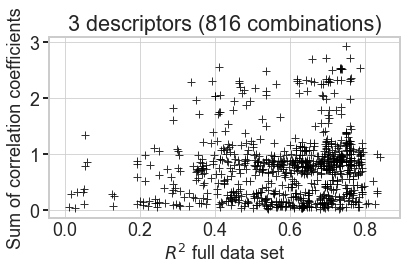

In [36]:
''' Plot the distribution of descriptor correlations against the 
 R2 metric of the fit with these 3 descriptors. '''

font = {'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

fig , ax = plt.subplots()
sns.set_style("whitegrid")
ax.scatter(r_values,per,marker='+', color='black', alpha = 0.8)
ax.set_title('3 descriptors (816 combinations)')
ax.set_ylabel('Sum of correlation coefficients')
ax.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(outpath + 'correlation_coeff_3_descriptors.png')
plt.show()


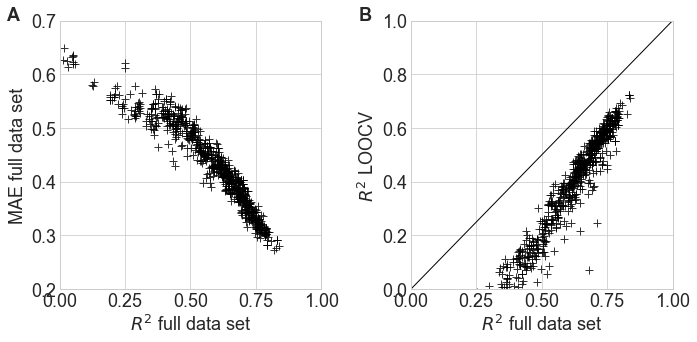

In [37]:
# Correlation between R2 and cv R2
fig, ((ax1, ax2)) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
sns.set_style("whitegrid")

ax1.scatter(r_values, all_mae, marker='+', color='black', alpha = 0.8)
ax1.set_ylim(0.2,0.7)
ax1.set_xlim(0,1)
ax1.text(-0.2,0.7,'A', weight='bold')
ax1.set_ylabel('MAE full data set')
ax1.set_xlabel('$R^2$ full data set')

ax2.plot([0,1], [0,1], color='black', lw=1.)
ax2.scatter(r_values, r2_cv, marker='+', color='black', alpha = 0.8)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.text(-0.2,1,'B', weight='bold')
ax2.set_ylabel(r'$R^2$ LOOCV')
ax2.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(outpath + 'ORR_R2_vs_LOOCV.png')
plt.show()


['$Z$(atom)', 'q(O)', 'Ox(M)']


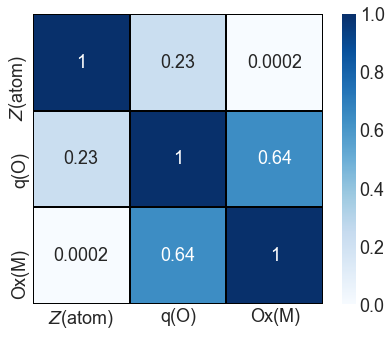

In [38]:
''' Plot Pearson descriptor correlations for the 3 features. '''
descriptor_bucket = ['Z_val_atom', 'q_O', 'active_site_oxidation_state']
train = df[descriptor_bucket]
# Pearson correlation of coefficients
xlist = [r'$Z$(atom)',  r'q(O)', r'Ox(M)']

# xlist = [w.replace('_', ' ') for w in xlist]
print(xlist)
corr = train.corr(method='pearson')**2
corr.columns = corr.columns.str.replace('_', ' ')
corr.index = corr.index.str.replace('_', ' ')
corr = corr.abs()
fig = plt.figure(figsize=(6, 5))
sns.heatmap(corr, cmap="Blues", square=True, vmin=0, vmax=1, 
            linecolor='black', linewidths=0.9, annot=True,
            xticklabels = xlist, yticklabels=xlist)
# plt.title(r'Pearson correlation of descriptors ORR')
plt.tight_layout()
fig_name = outpath + 'ORR_3_features_Pearson_correlation.pdf'                                                                                                                                                        
fig.savefig(fig_name)
plt.show()

Linear regression coefficients: 

Z_val_atom: 0.49
q_O: -3.63
active_site_oxidation_state: 1.11
Intercept: -9.64


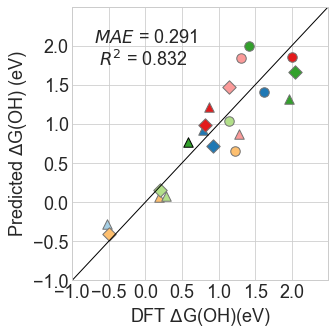

In [39]:
''' Parity plot for the best 3 descriptors. '''

# Features
X_best = df[descriptor_bucket]

# Targets
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

# Linear regression
clf = linear_model.LinearRegression()
clf.fit(X_best, y)
r_value = clf.score(X_best, y)
y_hat = clf.predict(X_best)

print('Linear regression coefficients: \n')
for i in range(3):
    print(list(X_best)[i]+': '+str(round(clf.coef_[i],2)))
print('Intercept: '+str(round(clf.intercept_,2)))

res = y_hat - y
mae = np.mean(np.abs(res))

# Parity plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)

msg = "$MAE$ = " + str(round(mae,3)) + '\n $R^2$ = ' + str(round(r_value, 3))
axmin = -1.
axmax = 2.5

plt.plot([axmin,axmax], [axmin,axmax], color='black', lw=1.)

for index, row in df.iterrows():
    key1 = int(row['metal_atomic_number'])
    key2 = int(row['n_H_atoms'])
    style_list=mdict[key1][key2]   
    if df['bridge'].iloc[index,] == 1.0:
        plt.scatter(y[index], y_hat[index], marker=style_list[8], color=style_list[9], 
                    edgecolors='black', label=style_list[1], s = 90.)
    else:
        plt.scatter(y[index], y_hat[index], marker=style_list[8], color=style_list[9], 
                    edgecolors=tcolor, label=style_list[1], s = 90.)

plt.gcf().subplots_adjust(bottom=0.18, left=0.18)
plt.xlabel(r'DFT $\Delta$G(OH)(eV)')
plt.ylabel(r'Predicted $\Delta$G(OH) (eV)')
plt.text(axmin*0.8+0.1, axmax*0.7, msg)

plt.xlim((axmin, axmax))
plt.ylim((axmin, axmax))
plt.xticks(np.arange(axmin, axmax,0.5))
plt.yticks(np.arange(axmin, axmax,0.5))
plt.tight_layout()
fig_name = outpath + 'ORR_parity_small_set.pdf'    
fig.savefig(fig_name)
plt.show()


In [40]:
# Randomize targets to get null distribution of R2 values
all_results = []

for i in range(100):
    # Targets small set
    target_values = list(df.filter(regex='ORR').columns)
    targets = df[target_values]
    targets = targets.astype('float64')
    targets = targets.sample(frac=1).reset_index(drop=True)
    target_name = 'ORR_dG_OH'
    
    y = targets[target_name]
    
    feature_dim = 3
    results = []
    for i, combo in enumerate(unique_set(features,feature_dim), 1):
        descriptor_combination = list(combo)
        X_combination = df[descriptor_combination]
    
        # Descriptor correlations
        correlations = []
        for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
            des_pairs = list(combo2)
            row = features.index(des_pairs[0])
            col = features.index(des_pairs[1])
            correlations.append(pearson_corr_matrix[row, col])
        corr_sum = sum(correlations)
        descriptor_combination.append(round(corr_sum,2))
        
        # Linear regression
        clf = linear_model.LinearRegression()
        clf.fit(X_combination, y)
        r_value = round(clf.score(X_combination, y),5)
        descriptor_combination.append(r_value)
    
        y_hat = clf.predict(X_combination)
        res = y_hat - y
        mae = round(np.mean(np.abs(res)),3)
        descriptor_combination.append(mae)
        results.append(descriptor_combination)
    
    
    # rank descriptor combinations
    results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
    per = np.asarray([x[feature_dim] for x in results_sorted])
    r_values_rnd = np.asarray([x[feature_dim + 1] for x in results_sorted])
    all_results.append(r_values_rnd)



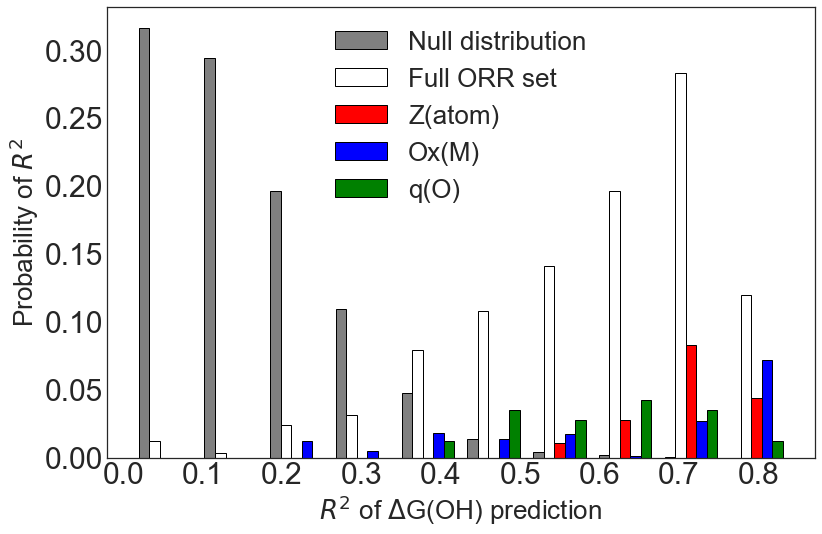

Mean of R2-values: 0.59


In [41]:
# Histogram of R2 score with null distribution
fig = plt.figure(figsize=(12, 8))
sns.set_style('white')
font = {'size': 26}
plt.rc('font', **font)

all_results_new = [item for sublist in all_results for item in sublist]
all_results_new = np.array(all_results_new)
weights1 = np.full(r_values.shape[0],1/len(r_values))
weights2 = weights1[0:r_values_z.shape[0]]
weights3 = weights1[0:r_values_ox.shape[0]]
weights4 = weights1[0:r_values_qO.shape[0]]
weights5 = np.full(all_results_new.shape[0],1/len(all_results_new))

# kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
hist, bin_edges = np.histogram(r_values, density = False, weights=weights1, bins=10)
plt.hist([all_results_new, r_values, r_values_z, r_values_ox, r_values_qO], bins=bin_edges, 
         color= ['grey', 'white', 'red', 'blue', 'green'], 
         weights = [weights5, weights1, weights2, weights3, weights4],
         label=['Null distribution', 'Full ORR set', 'Z(atom)', 'Ox(M)', 'q(O)'], edgecolor='black')

plt.legend()
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r'$R^2$ of $\Delta$G(OH) prediction')
plt.ylabel(r'Probability of $R^2$')
plt.tight_layout()
plt.show()

# Print some interesting statistic
print('Mean of R2-values: '+ str(round(np.mean(r_values),2)))

In [42]:
''' Test out 4 descriptors to see how much the R2-value improves 
 with respect to 3 descriptors'''

# Targets small set
target_values = list(df.filter(regex='ORR').columns)
# print(list(df))
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

feature_dim = 4
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    # Descriptor correlations
    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    # Linear regression
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    results.append(descriptor_combination)


# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE'+'\n')
for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)]
    if i <=5:
        print(result)


Number of combinations considered: 3060
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE

['q_O', 'e_form_rel', 'n_d_el_active', 'active_site_oxidation_state', 0.8, 0.86885, 0.248]
['Z_val_atom', 'q_O', 'e_form_rel', 'active_site_oxidation_state', 0.76, 0.86885, 0.248]
['Z_val_atom', 'q_O', 'e_form_rel', 'n_d_el_active', 1.17, 0.86885, 0.248]
['Z_val_bulk', 'q_M', 'e_form_rel', 'active_site_oxidation_state', 2.06, 0.86879, 0.243]
['Z_val_bulk', 'q_M', 'bridge', 'active_site_oxidation_state', 1.08, 0.86128, 0.257]
['q_O', 'e_form_rel', 'active_site_oxidation_state', 'c6', 0.7, 0.85503, 0.243]


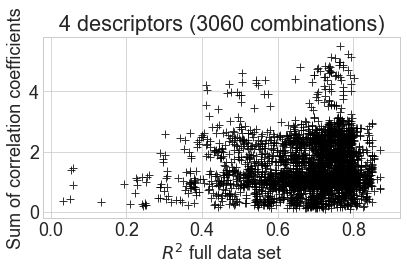

In [43]:
font = {'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
sns.set_style("whitegrid")
fig , ax = plt.subplots()

ax.scatter(r_values,per,marker='+', color='black', alpha = 0.8)
ax.set_title('4 descriptors (3060 combinations)')
ax.set_ylabel('Sum of correlation coefficients')
ax.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(outpath + 'correlation_coeff_3_descriptors.png')
plt.show()

In [44]:
''' Test out 2 descriptors to see how much the R2-value worsens 
 with respect to 3 descriptors. '''

# Targets small set
target_values = list(df.filter(regex='ORR').columns)
# print(list(df))
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

feature_dim = 2
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    # Descriptor correlations
    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    # Linear regression
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    results.append(descriptor_combination)

# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE'+'\n')
for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)]
    if i <=5:
        print(result)


Number of combinations considered: 153
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE

['active_site_oxidation_state', 'c6', 0.01, 0.78159, 0.313]
['Z_val_bulk', 'active_site_oxidation_state', 0.33, 0.75917, 0.33]
['Z_val_atom', 'q_M', 0.01, 0.74815, 0.329]
['n_d_el_active', 'active_site_oxidation_state', 0.23, 0.74756, 0.329]
['Z_val_atom', 'active_site_oxidation_state', 0.2, 0.74756, 0.329]
['Z_val_atom', 'n_d_el_active', 0.98, 0.74756, 0.329]
